In [ ]:
using Knet, Test, Base.Iterators, Printf, LinearAlgebra, Random, CUDA, IterTools, DelimitedFiles, Statistics
Knet.atype() = KnetArray{Float32}
#Knet.atype() = Array{Float32}
using Images, TestImages, OffsetArrays, Colors
using Plots
using JLD2

In [ ]:
include("models/transformer.jl")
include("dataloader/dataloader.jl")

In [ ]:
Knet.array_type[]

In [ ]:
# read  files
annotations = readdlm("archive/annotations_train.txt", '\t', String, '\n')[2:end,2:end]

# prepare vocab object
bow = ""
for sent in annotations[:,2]#
    bow *= sent
end
#bow = split(bow)
# bow wil be one giant sentence, corpus.
v = Vocab(bow)

# Initialize Iterators
img_iterator = ImgReader("archive/img_dirs_train.txt",load_and_process)
tgt_iterator = TextReader("archive/ann_caps_train.txt",v)

# simulate retrieving one batch
img_state, tgt_state = nothing, nothing
flag = true
iter = 1
batch = get_next_batch(img_iterator, tgt_iterator, img_state, tgt_state)

batch_imgs, batch_indices, img_state, tgt_state = batch
batch_imgs, batch_indices, labels = prepare_batch(batch, tgt_iterator)
println(iter)

In [ ]:
# build Image Caption Generating Transformer
transformer = Transformer(512, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, false)

# simulate forward training pass without autograd- returns loss value
transformer(batch_imgs, batch_indices, labels)

# simulate forward training pass with autograd- returns Tape object T
loss = @diff transformer(batch_imgs, batch_indices, labels; p=0.1, use_smooth_loss=true)

# updates
for p in params(transformer)
    #p .-= 0.1 .* grad(loss, p)
    diff_p = grad(loss, p)
    if diff_p == nothing
        continue
    else
        p .= p - (0.1 .* diff_p)
    end
end

# simulate inference
#sample_img, pred_sent = transformer(batch_imgs[:,:,:,1:1]);
word_probs = transformer(batch_imgs, batch_indices; p=0.1);
# println(tgt_iterator.vocab.i2w[pred_sent]);
# colorview(RGB, Array(sample_img))

In [ ]:
argmax(smooth_labels[:,4,3] .== positive_value)

In [ ]:
mapslices(argmax,Array(word_probs),dims=1)

In [ ]:
nll(word_probs, labels2)

In [ ]:
labels2 = labels[:,:]
labels2[labels2 .== 0] .= 1
labels2

In [ ]:
# OVERFIT TO SINGLE BATCH
# normalize images
batch_imgs_nomalized = 2.0 .* batch_imgs .- 1.0

transformer_conv = Transformer(128, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, true)
transformer_mlp = Transformer(512, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, false)
losses_conv = []
losses_mlp = []
for iter in 1:1:8000
    loss_conv = @diff transformer_conv(batch_imgs_nomalized, batch_indices, labels; p=0.2)
    loss_mlp = @diff transformer_mlp(batch_imgs_nomalized, batch_indices, labels; p=0.2)

    # updates
    for p in params(transformer_conv)
        diff_p = grad(loss_conv, p)
        if diff_p == nothing
            continue
        else
            p .= p - (0.01 .* diff_p)
        end
    end
    for p in params(transformer_mlp)
        diff_p = grad(loss_mlp, p)
        if diff_p == nothing
            continue
        else
            p .= p - (0.001 .* diff_p)
        end
    end

    println("iter: ", iter, "/8000")#, "loss: ", value(loss_conv))
    push!(losses_conv, value(loss_conv))
    push!(losses_mlp, value(loss_mlp))
end

In [ ]:
# OVERFIT TO SINGLE BATCH USING ADAM OPTIMIZER
# transformer_conv = Transformer(128, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, true)
# for p in params(transformer_conv)
#     p.opt = Adam(lr=compute_lr(128, 1; warmup_steps=4000), beta1=0.9, beta2=0.98, eps=1e-9, gclip=0)
# end

transformer_mlp = Transformer(512, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, false)
init_optimizer(transformer_mlp)
# for p in params(transformer_mlp)
#     p.opt = Adam(lr=compute_lr(512, 1; warmup_steps=4000), beta1=0.9, beta2=0.98, eps=1e-9, gclip=0)
# end

losses_conv = []
losses_mlp = []

# normalize images
batch_imgs_nomalized = 2.0 .* batch_imgs .- 1.0

for iter in 1:1:8000
    #loss_conv = @diff transformer_conv(batch_imgs_nomalized, batch_indices, labels; p=0.2, use_smooth_loss=false)
    loss_mlp = @diff transformer_mlp(batch_imgs_nomalized, batch_indices, labels; p=0.1, use_smooth_loss=true)

    # updates
#     ler=compute_lr(128, iter; warmup_steps=4000)
#     for p in params(transformer_conv)
#         g = grad(loss_conv, p)
#         if g == nothing
#             continue
#         else
#             update!(p, g)
#             #p .= p - (ler .* g)
#         end
#     end

#     ler=compute_lr(512, iter; warmup_steps=4000)
#     for p in params(transformer_mlp)
#         g = grad(loss_mlp, p)
#         if g == nothing
#             continue
#         else
#             #p.opt.lr=ler # update the lr attribute of the parameter's Adam optimizer object
#             #update!(p, g)
#             p .= p - (ler .* g)
#         end
#     end
    
    warm_adam_update(loss_mlp, transformer_mlp, iter)

    println("iter: ", iter, "/8000")#, "loss: ", value(loss_conv))
#     push!(losses_conv, value(loss_conv))
    push!(losses_mlp, value(loss_mlp))
end

In [ ]:
plot([losses_mlp], labels=["mlp"],xlabel="iterations",ylabel="NLL Loss")
# plot([losses_conv, losses_mlp], labels=["conv" "mlp"],xlabel="iterations",ylabel="NLL Loss")

In [ ]:
# simulate inference
sample_img, pred_sent = transformer_conv(batch_imgs[:,:,:,1:1]);
println(tgt_iterator.vocab.i2w[pred_sent]);
colorview(RGB, Array(sample_img))

In [ ]:
# simulate inference
sample_img, pred_sent = transformer_mlp(batch_imgs[:,:,:,1:1]);
println(tgt_iterator.vocab.i2w[pred_sent]);
colorview(RGB, Array(sample_img))

In [ ]:
### INSPECTION
# we have batch_imgs 400x400x3*20
# we have batch_indices 5*20
# we have labels 5*20

In [ ]:
# predict the words in batch form (NOT autoregressively)
word_probs = transformer_mlp(batch_imgs, batch_indices);

println("batch indices input:");
show(stdout, "text/plain", batch_indices);
println("\n");

println("word probs argmax ie transformer output:");
show(stdout, "text/plain", Array(mapslices(argmax,Array(word_probs),dims=1)[1,:,:]));
println("\n");

println("labels:")
show(stdout, "text/plain", labels);
println("\n");

labels2 = labels[:,:];
labels2[labels2.==0] .= 1;
println("labels2:")
show(stdout, "text/plain", labels2)

In [ ]:
si = 18 # a number [1,20] to select which sample from the batch we want to investigate

# show gt caption
println("GT caption");
println(tgt_iterator.vocab.i2w[labels2[:,si]]);
println("\n");

# convert predicted word prob argmax to english
println("predicted (non-autoregressive) caption");
println(tgt_iterator.vocab.i2w[mapslices(argmax,Array(word_probs),dims=1)[1,:,si]]);
println("\n");

# show image
colorview(RGB, Array(permutedims(batch_imgs[:,:,:,si],(3,1,2))))

In [ ]:
# MAIN TRAINING SCRIPT  - 13 minutes/epoch
# img_iterator = ImgReader("archive/img_dirs.txt",load_and_process)
# tgt_iterator = TextReader("archive/ann_caps.txt",v)

# Dataset has 8000 images
# Each batch is 4 images (4 unqiue, each with 5 captions, so batch size is actually 20)
# So there will be 1:2000 iterations for one epoch

exp_dir = "resfreeze"
mkpath("$exp_dir/ckpts")
mkpath("$exp_dir/losses")

#transformer_conv = Transformer(128, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, true)
#transformer_mlp_128 = Transformer(128, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, false)
transformer_conv_512 = Transformer(512, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, true)
#init_optimizer(transformer_conv)
#init_optimizer(transformer_mlp_128)
init_optimizer(transformer_conv_512)

#losses_conv = []
#losses_mlp_128 = []
losses_conv_512 = [] # stores the losses across entire training session, one average per iteration/minibatch
val_losses = []     # stores the average loss across entire val dataset, one per epoch
train_losses = []   # stores the average loss across entire train dataset, one per epoch
iter = 1
for epoch in 1:1:50
    # ONE TRAINING EPOCH LOOP
    train_loss = []
    println("\n"," epoch: ", epoch, "\n")
    
    img_state, tgt_state = nothing, nothing
    img_iterator = ImgReader("archive/img_dirs_train.txt",load_and_process)
    tgt_iterator = TextReader("archive/ann_caps_train.txt",v)
    while true #iter < 100 #flag !== nothing
        batch = get_next_batch(img_iterator, tgt_iterator, img_state, tgt_state)
        if batch == nothing
            break
        end
        batch_imgs, batch_indices, img_state, tgt_state = batch
        batch_imgs, batch_indices, labels = prepare_batch(batch, tgt_iterator)
        batch_imgs_nomalized = 2.0 .* batch_imgs .- 1.0

        #loss_conv = @diff transformer_conv(batch_imgs, batch_indices, labels, true)
        #loss_mlp_128 = @diff transformer_mlp_128(batch_imgs, batch_indices, labels, true)
        loss_conv_512 = @diff transformer_conv_512(batch_imgs_nomalized, batch_indices, labels; p=0.1, use_smooth_loss=true)

        # updates
        #warm_adam_update(loss_conv, transformer_conv, iter)
        #warm_adam_update(loss_mlp_128, transformer_mlp_128, iter)
        warm_adam_update(loss_conv_512, transformer_conv_512, iter; freeze=true)

        println("iter: ", iter%2000, "/2000 ", "loss: ", value(loss_conv_512))
        #push!(losses_conv, value(loss_conv))
        #push!(losses_mlp_128, value(loss_mlp_128))
        push!(losses_conv_512, value(loss_conv_512))
        push!(train_loss, value(loss_conv_512))
        iter = iter + 1
    end
    push!(train_losses, mean(train_loss)) # to plot training loss, but per epoch, to compare against val
    Knet.save("$exp_dir/ckpts/transformer_conv_512_epoch$epoch.jld2","transformer",transformer_conv_512)
    
    # ONE VALIDATION EPOCH LOOP
    val_loss = []
    img_state, tgt_state = nothing, nothing
    img_iterator = ImgReader("archive/img_dirs_val.txt",load_and_process)
    tgt_iterator = TextReader("archive/ann_caps_val.txt",v)
    while true #iter < 100 #flag !== nothing
        batch = get_next_batch(img_iterator, tgt_iterator, img_state, tgt_state)
        if batch == nothing
            break
        end
        batch_imgs, batch_indices, img_state, tgt_state = batch
        batch_imgs, batch_indices, labels = prepare_batch(batch, tgt_iterator)
        batch_imgs_nomalized = 2.0 .* batch_imgs .- 1.0

        #loss_conv = @diff transformer_conv(batch_imgs, batch_indices, labels, true)
        #loss_mlp_128 = @diff transformer_mlp_128(batch_imgs, batch_indices, labels, true)
        push!(val_loss, transformer_conv_512(batch_imgs_nomalized, batch_indices, labels; p=0.0, use_smooth_loss=true))
    
    end
    push!(val_losses, mean(val_loss))
end

save_object("$exp_dir/losses/losses_conv_512.jld2", losses_conv_512)
save_object("$exp_dir/losses/val_losses.jld2", val_losses)
save_object("$exp_dir/losses/train_losses.jld2", train_losses)

# plot training loss - next cell
#plot([losses_conv, losses_mlp_128, losses_mlp_512], labels=["conv" "mlp-128" "mlp-512"],xlabel="iterations",ylabel="NLL Loss")

In [62]:
train_losses = load_object("$exp_dir/losses/train_losses.jld2")
val_losses = load_object("$exp_dir/losses/val_losses.jld2")
losses_conv_512 = load_object("$exp_dir/losses/losses_conv_512.jld2")

4000-element Vector{Any}:
 8.640727f0
 8.40327f0
 7.988569f0
 8.494794f0
 8.544936f0
 8.315959f0
 7.9966946f0
 8.539137f0
 8.215378f0
 8.267002f0
 8.195064f0
 8.673453f0
 8.374085f0
 ⋮
 5.211678f0
 5.5117903f0
 5.537262f0
 5.6086226f0
 5.007507f0
 5.8556876f0
 5.527961f0
 5.3846254f0
 5.419037f0
 5.244445f0
 5.541812f0
 4.8151307f0

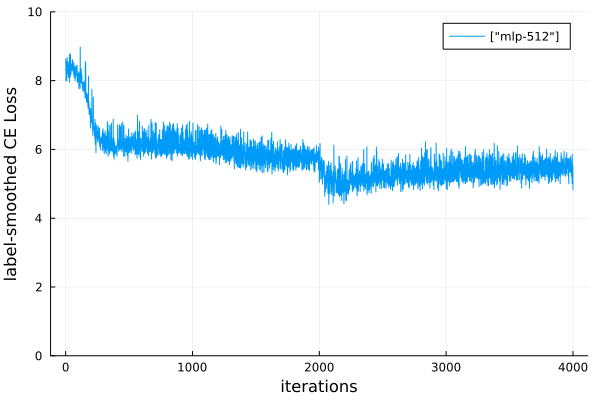

In [63]:
# plot training loss
#plot([losses_conv, losses_mlp_128, losses_mlp_512], labels=["conv" "mlp-128" "mlp-512"],ylim=(0.0, 30.0),xlabel="iterations",ylabel="NLL Loss")
plot([losses_conv_512], labels=["mlp-512"],ylim=(0.0, 10.0),xlabel="iterations",ylabel="label-smoothed CE Loss")

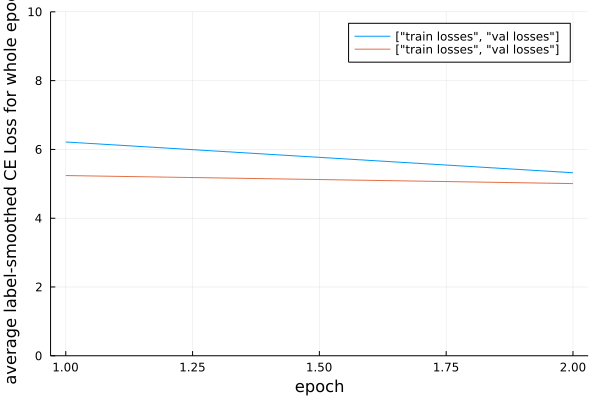

In [64]:
plot([train_losses, val_losses], labels=["train losses", "val losses"],ylim=(0.0, 10.0),xlabel="epoch", ylabel="average label-smoothed CE Loss for whole epoch")

In [ ]:
transformer_conv_512 = Transformer(512, length(tgt_iterator.vocab.i2w), tgt_iterator.vocab.eos, true)

In [ ]:
Knet.save("transformer_conv_512_epoch0.jld2", "transformer", transformer_conv_512)

In [ ]:
transformer_conv_512 = Knet.load("ckpts4/transformer_conv_512_epoch100.jld2","transformer")

In [ ]:
# predict the words in batch form (NOT autoregressively)
batch_imgs_nomalized = 2.0 .* batch_imgs .- 1.0
word_probs = transformer_conv_512(batch_imgs_nomalized, batch_indices);

println("batch indices input:");
show(stdout, "text/plain", batch_indices);
println("\n");

println("word probs argmax ie transformer output:");
show(stdout, "text/plain", Array(mapslices(argmax,Array(word_probs),dims=1)[1,:,:]));
println("\n");

println("labels:")
show(stdout, "text/plain", labels);
println("\n");

labels2 = labels[:,:];
labels2[labels2.==0] .= 1;
println("labels2:")
show(stdout, "text/plain", labels2)

In [ ]:
si = 2 # a number [1,20] to select which sample from the batch we want to investigate

for si in 1:20
    println("GT caption");
    println(tgt_iterator.vocab.i2w[labels2[:,si]]);
    println("\n");

    # convert predicted word prob argmax to english
    println("predicted (non-autoregressive) caption");
    println(tgt_iterator.vocab.i2w[mapslices(argmax,Array(word_probs),dims=1)[1,:,si]]);
    println("\n");

    # run auto-regressive inference
    _, pred_sent = transformer_conv_512(batch_imgs[:,:,:,si:si]);
    println("predicted autoregressive caption");
    println(tgt_iterator.vocab.i2w[pred_sent]);
    println("\n");
end

# show image
colorview(RGB, Array(permutedims(batch_imgs[:,:,:,si],(3,1,2))))

In [ ]:
# simulate inference
img_state, tgt_state = nothing, nothing
batch = get_next_batch(img_iterator, tgt_iterator, img_state, tgt_state)

batch_imgs, batch_indices, img_state, tgt_state = batch
batch_imgs, batch_indices, labels = prepare_batch(batch, tgt_iterator)

sample_img, pred_sent = transformer_mlp_512(batch_imgs[:,:,:,5:5]);
println(tgt_iterator.vocab.i2w[pred_sent]);
colorview(RGB, Array(sample_img))

In [ ]:
batch_indices

In [ ]:
labels

In [ ]:
# save model
Knet.save("transformer_mlp_128_epoch10.jld2","transformer",transformer_mlp_128)
Knet.save("transformer_mlp_512_epoch10.jld2","transformer",transformer_mlp_512)
Knet.save("transformer_conv_128_epoch10.jld2","transformer",transformer_conv)

In [ ]:
epoch=3
print("hello_epoch$epoch.jld2")

In [ ]:
# load model
pretrained = Knet.load("transformer_mlp_512_epoch10.jld2","transformer")

# simulate inference
sample_img, pred_sent = pretrained(batch_imgs[:,:,:,1:1]);
println(tgt_iterator.vocab.i2w[pred_sent]);
colorview(RGB, Array(sample_img))

In [ ]:
##################### INFERENCE DEBUGGING

In [ ]:
word_probs = pretrained(batch_imgs, batch_indices)

In [ ]:
batch_indices

In [ ]:
mapslices(argmax,Array(word_probs),dims=1)[1,:,:]

In [ ]:
labels

In [ ]:
word_probs = pretrained(batch_imgs[:,:,:,1:1], reshape([1350, 65, 32],(3,1)))#batch_indices[1:1,1:1])

In [ ]:
reshape([1350],(1,1))

In [ ]:
mapslices(argmax,Array(word_probs),dims=1)